In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score

!pip install torch torchvision torchaudio tensorflow

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
from tensorflow.keras.preprocessing import image
from PIL import Image  
import shutil
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
from sklearn.model_selection import train_test_split
from torchvision.models import resnet50
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter

2025-03-12 20:00:43.376888: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!pip install torch torchvision torchaudio tensorflow


### Project Overview and structure
The following project will follow 4 main steps to achieve all its objectives and a sucessfull completion:

1. Preprocess and enhance breast ultrasound images to enhance the analysis of the image.
2. Segment the tumor regions using thresholding.
3. Use image subtraction to highlight tumor growth between aligned baseline and follow-up images.
4. Classify the tumors into benign and malignant using shape and texture features.

Hence, each of the following steps below will be following or achieving one of the above stated objectives.

## 1. Preprocessing and Dataset Intro - Preparing our Data

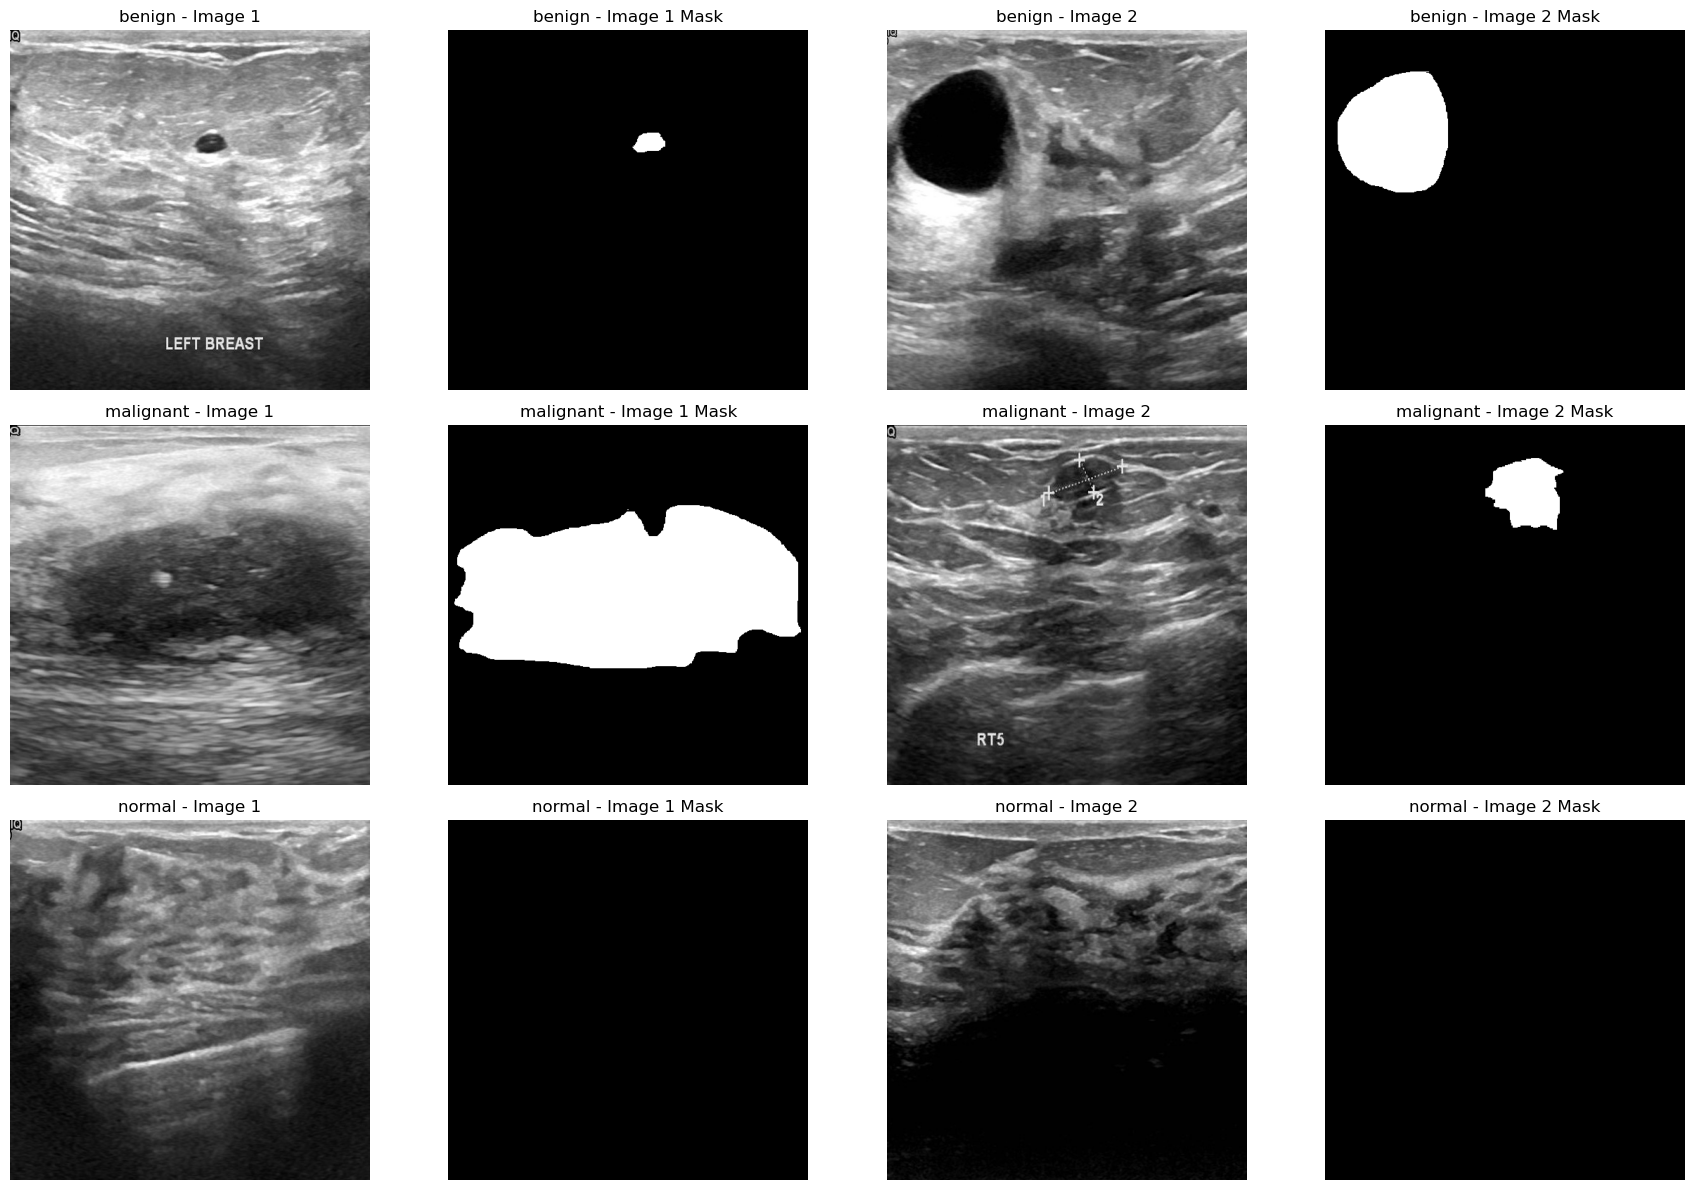

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score

#Setting the labels according to active directories
labels = ['benign', 'malignant', 'normal']
data_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Dataset_BUSI_with_GT'
working_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Working Dir'
# Create a figure to display the images
fig, axs = plt.subplots(3, 4, figsize=(18, 12))

#Resizing
desired_width = 512  
desired_height = 512 

for i, label in enumerate(labels):
    label_dir = os.path.join(data_dir, label)
    
    #Get a list of image files
    image_files = [file for file in os.listdir(label_dir) if file.endswith('.png')]
    image_files = sorted(image_files)
    
    #Checking through the first 4 images
    for j in range(4):
        if j < len(image_files):
            #Load and resize the image
            image_path = os.path.join(label_dir, image_files[j])
            image = Image.open(image_path)
            image = image.resize((desired_width, desired_height), Image.LANCZOS)
            
            #Strategy to check if its an image or mask.
            if j % 2 == 0:
                image_label = f'{label} - Image {j // 2 + 1}'
            else:
                image_label = f'{label} - Image {j // 2 + 1} Mask'
            
            #Show image
            axs[i, j].imshow(image)
            axs[i, j].set_title(image_label)
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()


I used the ultrasound scans directly categorized into three classes: benign, malignant, and normal. 
Each category contains two ultrasound images along with their corresponding **segmentation masks**, which highlight the regions of interest.

The **benign images**, highlight well defined & round structures with clear cut boundaries. 
The **malignant images** show irregular shapes with diffuse borders, indicating potential cancerous growth.

The **segmentation masks** for malignant tumors cover a more irregular and larger area compared to the benign ones. 
The **normal** breast scan images have no significant segmentation regions, **as expected**, indicating the absence of abnormal structures. 

## 2. Image Processing Tasks with the UltraSound Scans in our Datasets.

In [4]:
def preprocess1(label):
    label_dir = os.path.join(data_dir, label)
    image_files = sorted([file for file in os.listdir(label_dir) if file.endswith('.png')])

    images = []
    masks = []

    for j in range(len(image_files)):
        image_path = os.path.join(label_dir, image_files[j])
        #The images may already be grayscale in the dataset, however, reapplied to ensure that it is grayscale.
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  

        if image is not None:
            image = cv2.resize(image, (desired_width, desired_height))  # Resize
            equalized = cv2.equalizeHist(image)
            processed_image = cv2.GaussianBlur(equalized, (5, 5), 0)
            if j % 2 == 0:
                images.append(processed_image)  
            else:
                masks.append(processed_image)   

    return images, masks

# Load images for each label
image_data = {label: preprocess1(label) for label in labels}


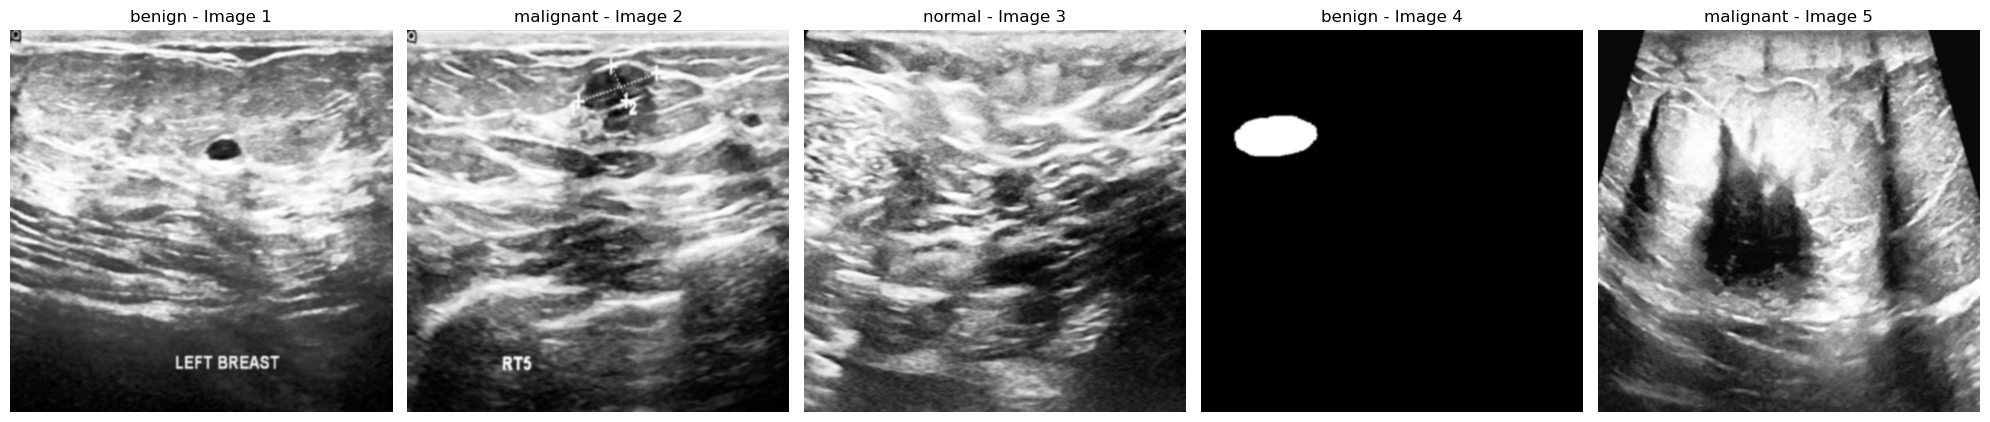

In [5]:
num_images_to_display = 5

# Create a figure with subplots
fig, axs = plt.subplots(1, num_images_to_display, figsize=(20, 5))

# Iterate over the first 5 images
for i in range(num_images_to_display):
    label = labels[i % len(labels)]  # Cycle through labels if less than 5 images in one category
    image = image_data[label][0][i]  # Get the first 5 processed images

    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(f'{label} - Image {i+1}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [6]:
#Comparison of images above
def preprocess2(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    equalized = cv2.equalizeHist(gray)  # Enhance contrast
    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)  # Reduce noise
    return blurred


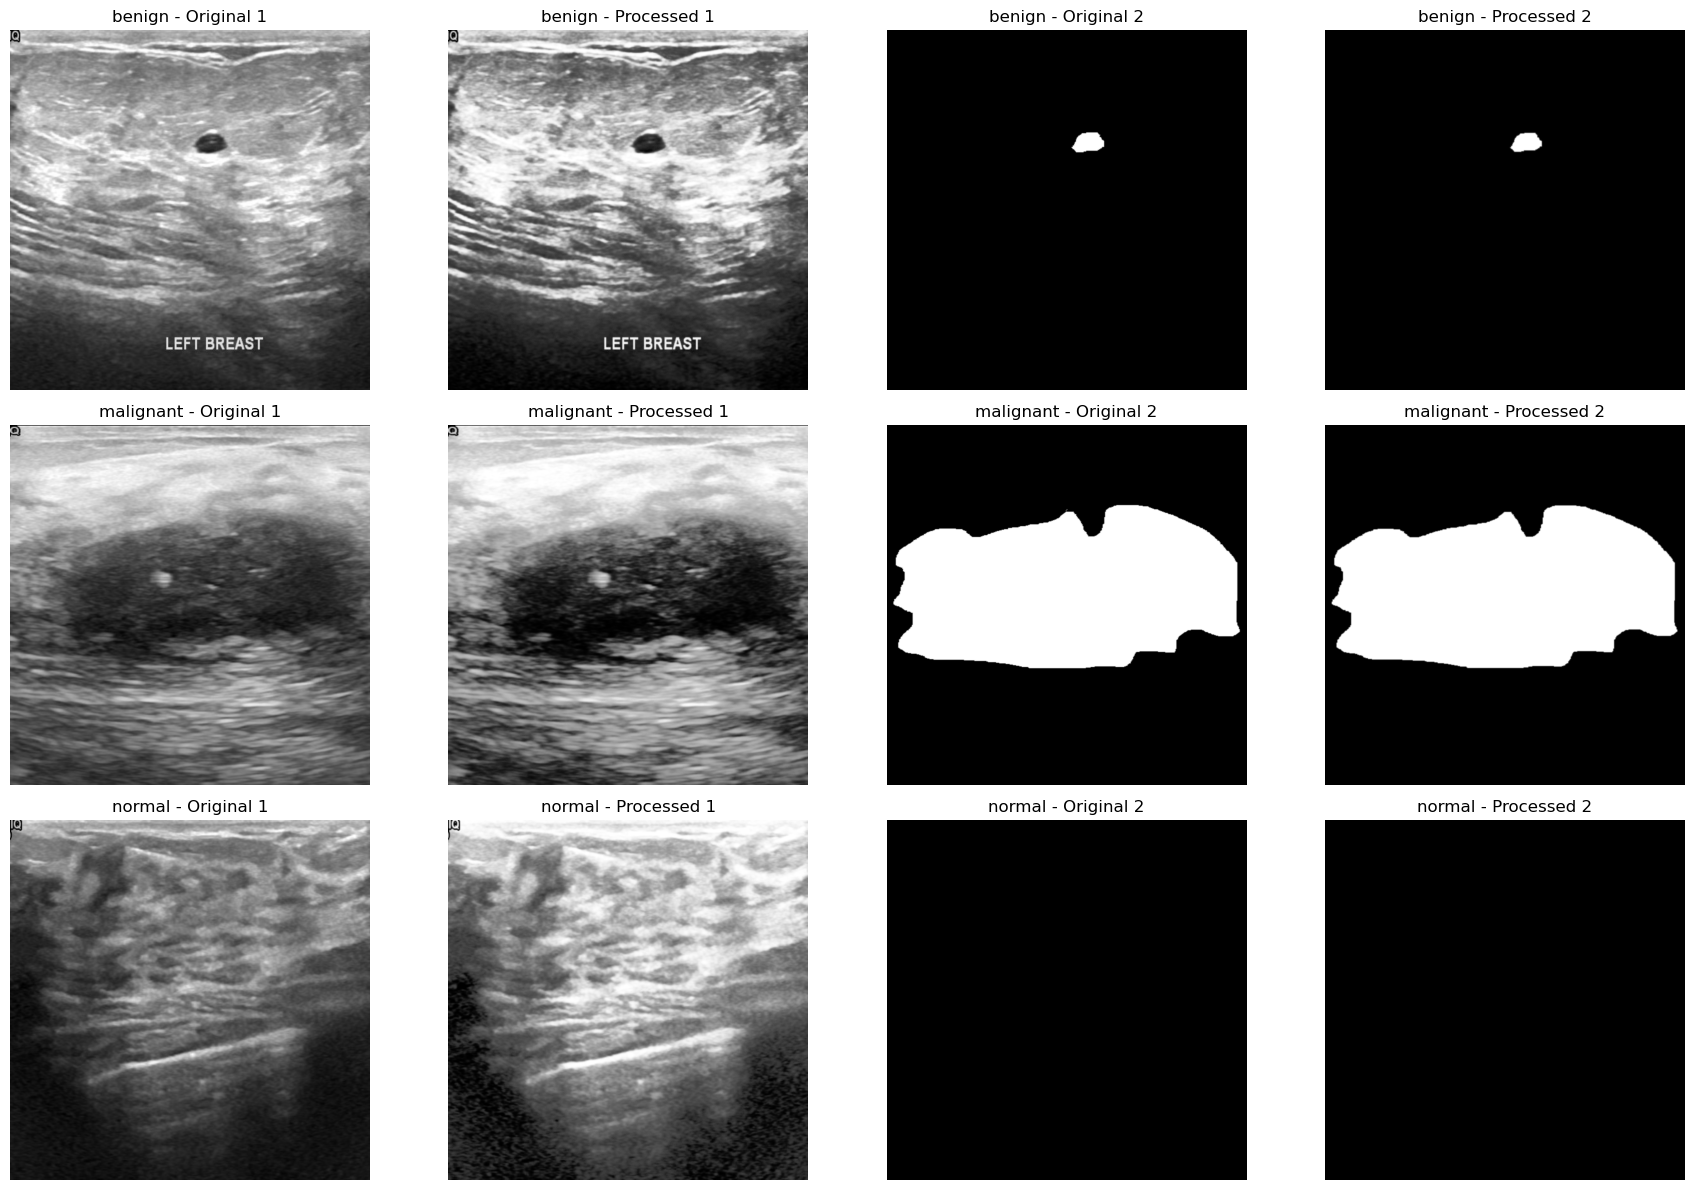

In [7]:
#Better dimensions
desired_width = 1280  
desired_height = 1280

def preprocess_image(image):
    #Ensuring that the images are grayscale.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  
    #Noise Reduction & Contrast
    equalized = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)  
    return blurred

fig, axs = plt.subplots(3, 4, figsize=(18, 12)) 

for i, label in enumerate(labels):
    label_dir = os.path.join(data_dir, label)
    
    #Get a list of image files
    image_files = sorted([file for file in os.listdir(label_dir) if file.endswith('.png')])

    #Checking through the first 2 original & processed images 
    for j in range(2):  
        if j < len(image_files):
            #Load original image
            image_path = os.path.join(label_dir, image_files[j])
            image = cv2.imread(image_path)
            image = cv2.resize(image, (desired_width, desired_height))  
            processed_image = preprocess2(image)

            #Original Image
            axs[i, j * 2].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
            axs[i, j * 2].set_title(f'{label} - Original {j+1}')
            axs[i, j * 2].axis('off')

            #Processed Image 
            axs[i, j * 2 + 1].imshow(processed_image, cmap='gray')  
            axs[i, j * 2 + 1].set_title(f'{label} - Processed {j+1}')
            axs[i, j * 2 + 1].axis('off')
plt.tight_layout()
plt.show()

## Preliminary

In [8]:
# Define the minority classes in your dataset
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

# Define custom data transformations for minority classes
minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),  # Apply with 90% probability
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Define data transformations for train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # Apply custom augmentations to minority classes
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [9]:
pwd

'/Users/cdmstudent/Downloads/Img Proccesign Final Project'

In [10]:
# Define the training function with early stopping and additional features
# Lists to store training and validation losses
train_losses = []
val_losses = []
def train_model_with_early_stopping(model, lossFunction, optimizer, scheduler, dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')  # Initialize best_loss with a large value
    consecutive_epochs_without_improvement = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Append training loss here
                if phase == 'train':
                    train_losses.append(loss.item())  # Append training loss
                else:
                    val_losses.append(loss.item())  # Append validation loss

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Early stopping: Check if validation loss improved
            if phase == 'validation':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    consecutive_epochs_without_improvement = 0
                else:
                    consecutive_epochs_without_improvement += 1


                val_losses.append(epoch_loss)

        # Check if early stopping criteria are met
        if consecutive_epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch} epochs")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:.4f}'.format(best_loss))
   
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Calculate classification report and confusion matrix for validation data
    y_true = []
    y_pred = []

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate classification report
    target_names = [str(class_names[i]) for i in range(len(class_names))]
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    return model

In [11]:
import warnings

# Suppress DeprecationWarning and ResourceWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ResourceWarning)

# Set the path to the input folder containing images and masks
input_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Dataset_BUSI_with_GT'

# Set the path to the output folder where overlayed images will be saved
output_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Working Dir/OverlayedImages'

# Create subdirectories for each label
labels = ['benign', 'malignant', 'normal']
for label in labels:
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)

# Function to overlay images and masks, resize if needed, and save the result
def overlay_and_save(image_path, mask_path, output_path):
    try:
        # Check if both image and mask files exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            # Open the actual image and mask image
            image = Image.open(image_path)
            mask = Image.open(mask_path)

            # Ensure both images have the same color mode
            if image.mode != mask.mode:
                mask = mask.convert(image.mode)

            # Resize the images if their sizes don't match
            if image.size != mask.size:
                image = image.resize(mask.size)

            # Overlay the image with the mask
            overlayed = Image.blend(image, mask, alpha=0.5)

            # Save the overlayed image to the appropriate label folder
            label = os.path.basename(os.path.dirname(image_path))
            output_path = os.path.join(output_dir, label, os.path.basename(image_path))
            overlayed.save(output_path)
        else:
            #print(f"File not found for: {image_path} or {mask_path}. Skipping...")
            pass
    except Exception as e:
        print(f"An error occurred for: {image_path} or {mask_path}. Error: {str(e)}")

# Iterate through the subdirectories (benign, malignant, normal)
for label in labels:
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        for image_filename in os.listdir(label_dir):
            if image_filename.endswith('.png'):
                image_path = os.path.join(label_dir, image_filename)
                # Construct the mask file path based on the naming convention
                mask_filename = image_filename.replace('.png', '_mask.png')
                mask_path = os.path.join(label_dir, mask_filename)
                overlay_and_save(image_path, mask_path, output_dir)

print("Overlayed images have been saved to working directory - Overlayed images.")

Overlayed images have been saved to working directory - Overlayed images.


In [12]:
import os

# Function to count the number of files in a directory
def count_files_in_directory(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

# Set the paths to the input and output directories
input_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Dataset_BUSI_with_GT'
output_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Working Dir/OverlayedImages'

# Count the files in the input and output directories
input_counts = {}
output_counts = {}

# Count files in input directory
for label in os.listdir(input_dir):
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        input_counts[label] = count_files_in_directory(label_dir)

# Count files in output directory
for label in os.listdir(output_dir):
    label_dir = os.path.join(output_dir, label)
    if os.path.isdir(label_dir):
        output_counts[label] = count_files_in_directory(label_dir)

# Print file counts
print("File Counts Before Overlay-includes masks:")
for label, count in input_counts.items():
    print(f"{label}: {count} files")

print("\nFile Counts After Overlay:")
for label, count in output_counts.items():
    print(f"{label}: {count} files")

File Counts Before Overlay-includes masks:
malignant: 421 files
benign: 891 files
normal: 266 files

File Counts After Overlay:
malignant: 210 files
benign: 440 files
normal: 133 files


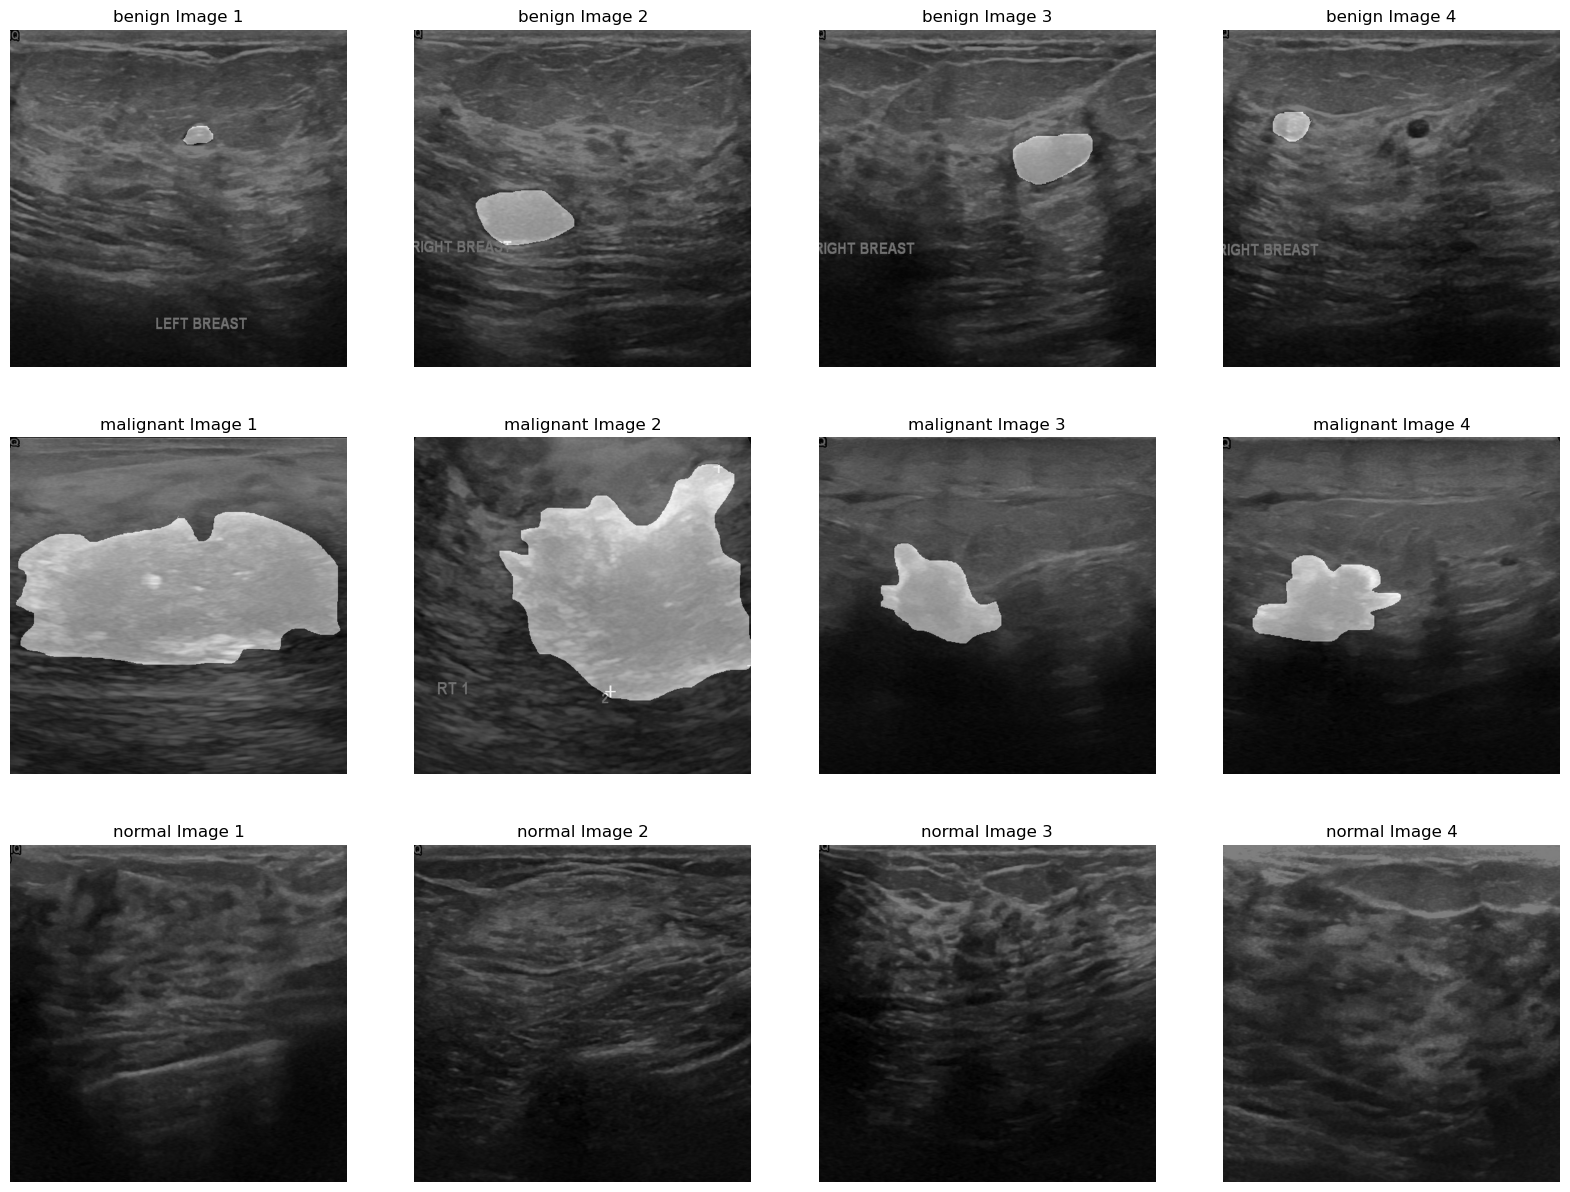

In [13]:
# Set the path to the overlayed images directory
overlayed_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Working Dir/OverlayedImages'

# Create subdirectories for each label
labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(overlayed_dir, label) for label in labels]

# Create a figure to display the images
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

# Desired width and height for each image
desired_width = 800  # Adjust as needed
desired_height = 800  # Adjust as needed

# Loop through each label and display the first 4 images
for i, label_dir in enumerate(label_dirs):
    # Get a list of image files and sort them
    images = [image for image in os.listdir(label_dir) if image.endswith('.png')]
    images.sort(key=lambda x: int(x.split('(')[1].split(')')[0]))  # Sort the images by number in parentheses

    for j, image_filename in enumerate(images[:4]):  # Display the first 4 images
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)

        # Resize the image to the desired width and height
        image = image.resize((desired_width, desired_height), Image.LANCZOS)

        # Display the image in the subplot
        axs[i, j].imshow(image)
        axs[i, j].set_title(f'{labels[i]} Image {j + 1}')
        axs[i, j].axis('off')

plt.show()

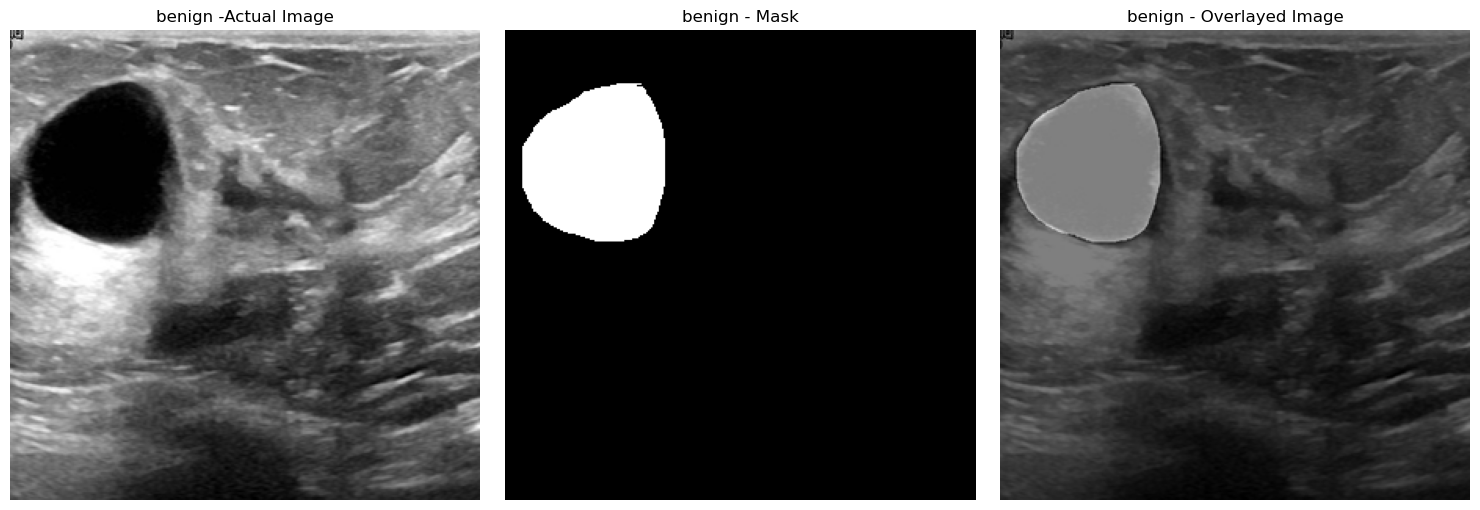

In [14]:
# Define the directory paths
input_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Dataset_BUSI_with_GT'
overlayed_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Working Dir/OverlayedImages/benign'

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Desired width and height for display
desired_width = 300
desired_height = 300

# Select an image (change the index as needed)
image_filename = 'benign (10).png'

# Construct the file paths
actual_image_path = os.path.join(input_dir, 'benign', image_filename)
mask_image_path = os.path.join(input_dir, 'benign', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

# Load the images
actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

# Resize the images
actual_image = actual_image.resize((desired_width, desired_height), Image.LANCZOS)
mask_image = mask_image.resize((desired_width, desired_height), Image.LANCZOS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.LANCZOS)

# Display the images
axs[0].imshow(actual_image)
axs[0].set_title('benign -Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('benign - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('benign - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()


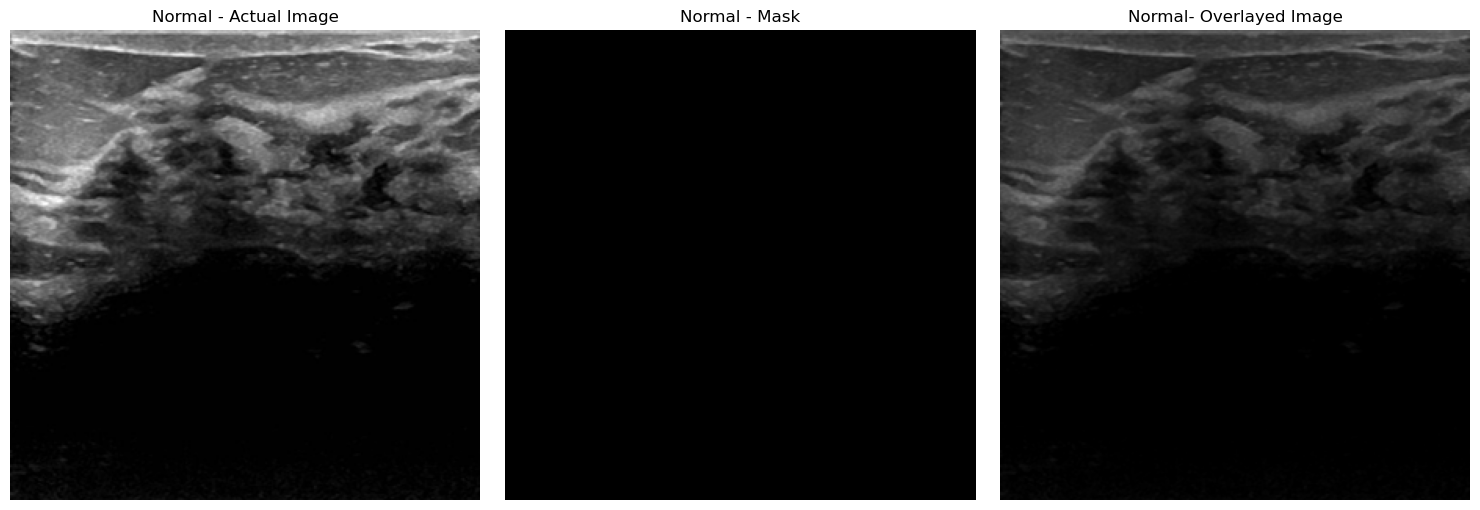

In [15]:
# Define the directory paths
input_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Dataset_BUSI_with_GT'
overlayed_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Working Dir/OverlayedImages/normal'

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Desired width and height for display
desired_width = 300
desired_height = 300

# Select an image (change the index as needed)
image_filename = 'normal (10).png'

# Construct the file paths
actual_image_path = os.path.join(input_dir, 'normal', image_filename)
mask_image_path = os.path.join(input_dir, 'normal', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

# Load the images
actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

# Resize the images
actual_image = actual_image.resize((desired_width, desired_height), Image.LANCZOS)
mask_image = mask_image.resize((desired_width, desired_height), Image.LANCZOS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.LANCZOS)

# Display the images
axs[0].imshow(actual_image)
axs[0].set_title('Normal - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('Normal - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('Normal- Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

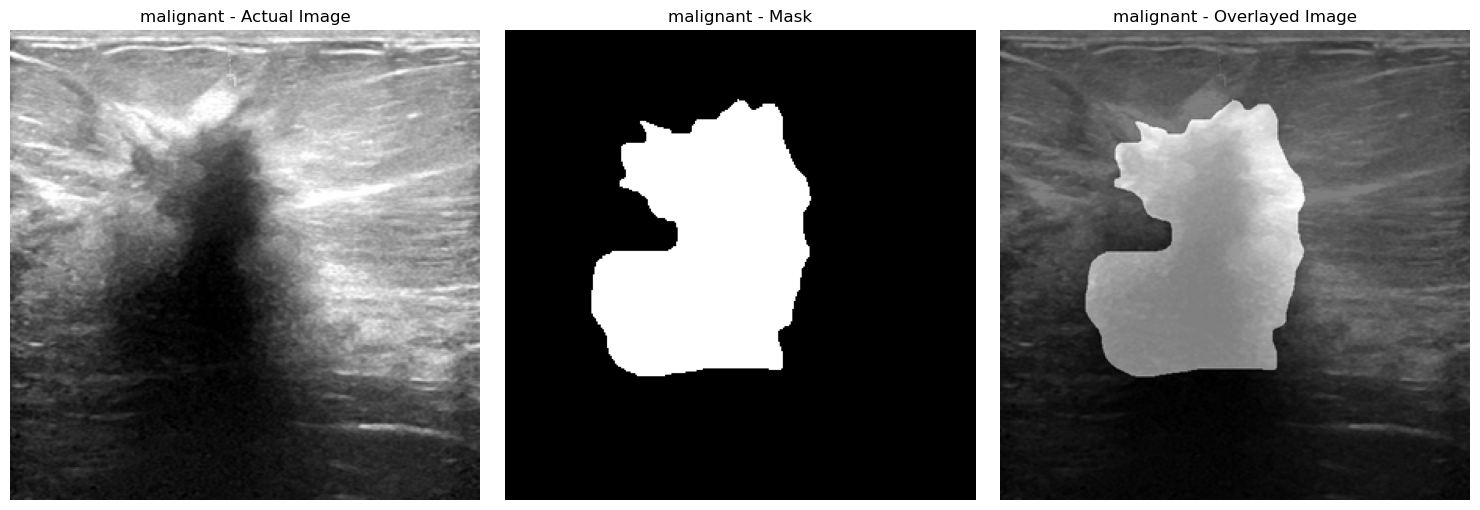

In [16]:

# Define the directory paths
input_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Dataset_BUSI_with_GT'
overlayed_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Working Dir/OverlayedImages/malignant'

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Desired width and height for display
desired_width = 300
desired_height = 300

# Select an image (change the index as needed)
image_filename = 'malignant (103).png'

# Construct the file paths
actual_image_path = os.path.join(input_dir, 'malignant', image_filename)
mask_image_path = os.path.join(input_dir, 'malignant', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

# Load the images
actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

# Resize the images
actual_image = actual_image.resize((desired_width, desired_height), Image.LANCZOS)
mask_image = mask_image.resize((desired_width, desired_height), Image.LANCZOS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.LANCZOS)

# Display the images
axs[0].imshow(actual_image)
axs[0].set_title('malignant - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('malignant - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('malignant - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [17]:
import pandas as pd
data_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Working Dir/OverlayedImages'

# Create a list to store file paths and labels
file_paths = []
labels = []

# Loop through the subdirectories (benign, malignant, normal)
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or 
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

# Create a DataFrame to store the file paths and labels
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

# Split the dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

# Define the paths for the train, validation, and test directories
train_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Working Dir/train'
val_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Working Dir/validation'
test_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Working Dir/test'

# Create the train, validation, and test directories and subdirectories
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Copy the images to the corresponding directories
for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))

In [18]:
import os
train_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Working Dir/train'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
   # print("Train folder counts including masks:")
    print(f"Train {category}: {count}")

validation_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Working Dir/validation'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(validation_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("Validation folder counts including masks:")
    print(f"Validation {category}: {count}")


test_dir = '/Users/cdmstudent/Downloads/Img Proccesign Final Project/Working Dir/test'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("test folder counts including masks:")
    print(f"test {category}: {count}")

Train benign: 316
Train malignant: 153
Train normal: 97
Validation benign: 56
Validation malignant: 27
Validation normal: 17
test benign: 67
test malignant: 31
test normal: 20


In [5]:
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

# Fix the data directory path
data_dir = os.path.expanduser('~/Downloads/Img Proccesign Final Project/Working Dir')

# Define transformations (modify as needed)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images
        transforms.ToTensor(),
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# Check if directories exist
for x in ['train', 'validation', 'test']:
    folder_path = os.path.join(data_dir, x)
    if not os.path.exists(folder_path):
        print(f"Warning: The directory '{folder_path}' does not exist!")

# If directories exist, create datasets
image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
    if os.path.exists(os.path.join(data_dir, x))  # Ensure existence before loading
}

# Specify batch size
batch_size = 8  

# Create dataloaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
    for x in image_datasets  # Avoids errors if a dataset is missing
}

# Calculate dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets}

# Get class labels if train dataset exists
if 'train' in image_datasets:
    class_names = image_datasets['train'].classes
else:
    class_names = []

# Print dataset sizes and class labels
print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)


Dataset Sizes: {'train': 563, 'validation': 100, 'test': 117}
Class Labels: ['benign', 'malignant', 'normal']


In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained ResNet-50 model correctly
resnet50_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Print model summary
print(resnet50_model)

# Enable training for all parameters
for param in resnet50_model.parameters():
    param.requires_grad = True

# Get the number of input features for the last fully connected (FC) layer
in_features = resnet50_model.fc.in_features

# Define number of output classes
num_classes = len(class_names)  # Ensure class_names is defined

# Replace the final FC layer with a new one
resnet50_model.fc = nn.Linear(in_features, num_classes)

# Print modified model
print(resnet50_model.fc)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Define the optimizer
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.00005)

# Learning rate scheduler: decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define loss function
Loss_Function = nn.CrossEntropyLoss()


In [10]:
import torch
import time
import copy

def train_model_with_early_stopping(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0  # Early stopping counter

    since = time.time()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Save best model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0  # Reset early stopping counter
            elif phase == 'validation':
                epochs_no_improve += 1

        # Adjust learning rate
        scheduler.step()

        # Check early stopping
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best validation Acc: {best_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [11]:
import os
import torch

# Define correct save path
save_dir = os.path.expanduser('~/Downloads/Img Proccesign Final Project/Working Dir')
save_path = os.path.join(save_dir, "resnet50_fineTuning.pth")  # Use .pth instead of .h5 for PyTorch

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Move model to correct device
resnet50_fineTuning = resnet50_model.to(device)

# Train model with early stopping
model_fineTuning = train_model_with_early_stopping(
    resnet50_fineTuning, Loss_Function, optimizer, scheduler, 
    dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2
)

# Save trained model
torch.save(model_fineTuning.state_dict(), save_path)
print(f"Model saved to {save_path}")


Epoch 1/20
------------------------------
train Loss: 0.7797 Acc: 0.6679
validation Loss: 0.6758 Acc: 0.8300
Epoch 2/20
------------------------------
train Loss: 0.2739 Acc: 0.9556
validation Loss: 0.2151 Acc: 0.9800
Epoch 3/20
------------------------------
train Loss: 0.1208 Acc: 0.9787
validation Loss: 0.1531 Acc: 0.9800
Epoch 4/20
------------------------------
train Loss: 0.0553 Acc: 0.9911
validation Loss: 0.2297 Acc: 0.9800
Early stopping triggered!
Training complete in 12m 20s
Best validation Acc: 0.9800
Model saved to /Users/cdmstudent/Downloads/Img Proccesign Final Project/Working Dir/resnet50_fineTuning.pth


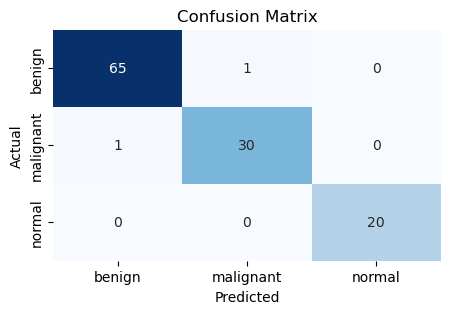

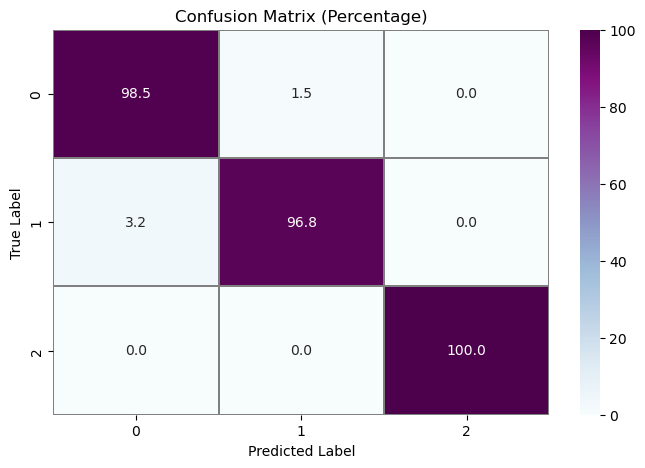

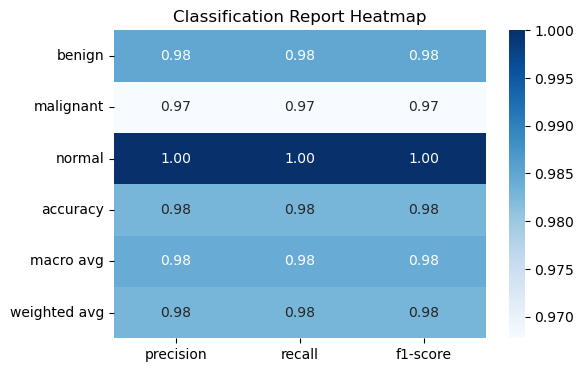

Simplified Classification Report:
             benign  malignant  normal  accuracy  macro avg  weighted avg
precision  0.984848   0.967742     1.0  0.982906   0.984197      0.982906
recall     0.984848   0.967742     1.0  0.982906   0.984197      0.982906
f1-score   0.984848   0.967742     1.0  0.982906   0.984197      0.982906


NameError: name 'train_losses' is not defined

In [15]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Define label names
label_names = [str(class_names[i]) for i in range(len(class_names))]

# Calculate classification report and confusion matrix on unseen test data
y_true = []
y_pred = []

model_fineTuning.eval()  # Set model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_fineTuning(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Generate classification report
classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

# Generate confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with label names
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate the percentage confusion matrix
confusion_mtx_percent = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Convert the classification report to a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')  # Simplify classification report
plt.title('Classification Report Heatmap')
plt.show()

# Print the simplified classification report
print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])  # Display without support and avg/total rows

# Plotting the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


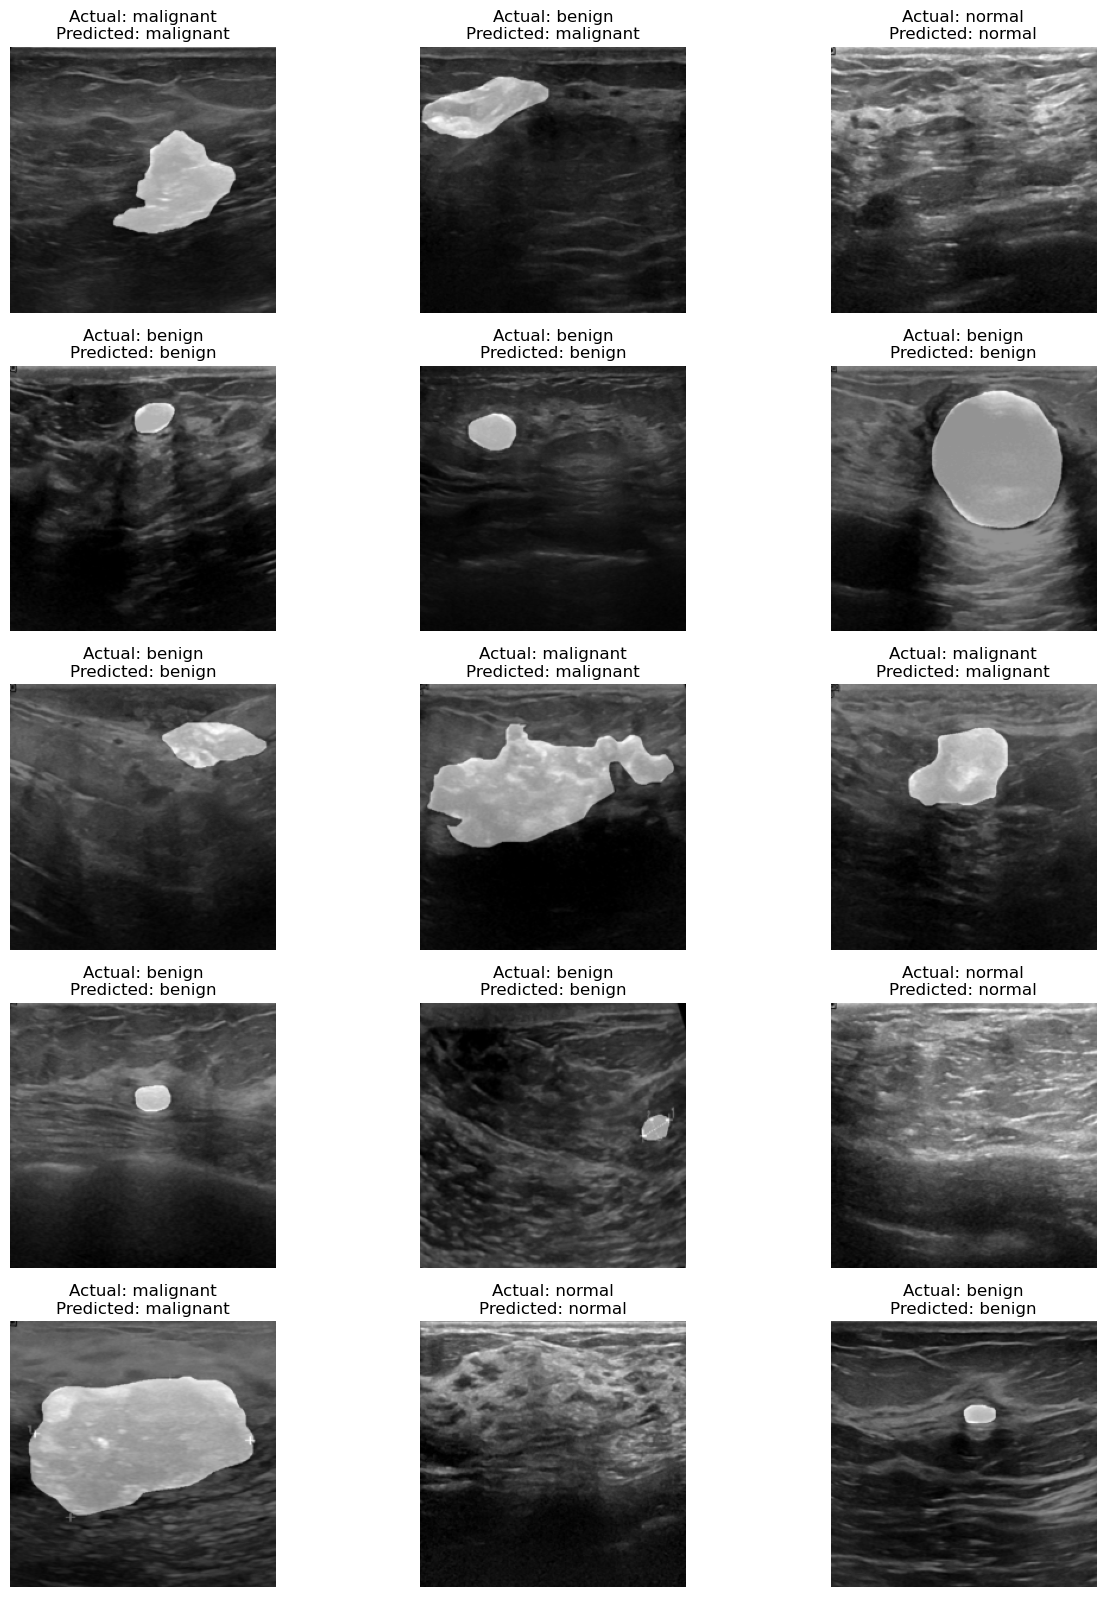

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Set the number of images to display
num_images_to_display = 15

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(image_datasets['test'], batch_size=num_images_to_display, shuffle=True, num_workers=4)

# Get a batch of test data
inputs, labels = next(iter(test_dataloader))

# Move inputs to the device
inputs = inputs.to(device)

# Convert images to grayscale
grayscale_images = inputs.cpu().numpy().mean(axis=1)  # Convert RGB to grayscale

# Get model predictions
with torch.no_grad():
    model_fineTuning.eval()
    outputs = model_fineTuning(inputs)
    _, preds = torch.max(outputs, 1)

# Plot the grayscale images with labels and predictions
plt.figure(figsize=(15, 20))  # Increase the height to accommodate 5 rows
for i in range(num_images_to_display):
    ax = plt.subplot(5, 3, i + 1)  # Adjust the layout to 5 rows by 3 columns
    ax.axis('off')
    ax.set_title(f'Actual: {class_names[labels[i]]}\nPredicted: {class_names[preds[i]]}')
    plt.imshow(grayscale_images[i], cmap='gray')  # Display the grayscale image

plt.show()
